In [1]:
%pylab inline
import os,sys
rootDir = '..'
sys.path.extend([rootDir,os.path.join(rootDir,'bok'),os.path.join(rootDir,'cfht')])
seterr(all='ignore')
from astropy.table import Table,hstack,join
from astropy.stats import sigma_clip
import idmrmphot,bokrmphot,cfhtrmphot
photDir = os.path.join(rootDir,'archive','nov_2017_selfcalv1')

Populating the interactive namespace from numpy and matplotlib


In [2]:
obsCfg = {'bok':bokrmphot.BokConfig(),'cfht':cfhtrmphot.CfhtConfig()}
zeropoints = {'bok':Table.read(os.path.join(rootDir,'bok','data','BokRMFrameList.fits.gz')),
             'cfht':Table.read(os.path.join(rootDir,'cfht','config','CFHTRMFrameList.fits.gz'))}

In [3]:
sdssStars = idmrmphot.load_target_catalog('sdss')
sdssStars.refCat['g-i'] = sdssStars.refCat['g'] - sdssStars.refCat['i']

In [4]:
allPhot = { k:Table.read(os.path.join(photDir,k+'rmphot_sdssrefstars.fits'))
              for k in ['bok','cfht'] }

In [5]:
# no split for Bok
# splits CFHT by <2014, 2014-2015, >= 2016
colorEpochs = {'bok':[99999],'cfht':[57000,57350,99999]}

In [6]:
phot = {}
for k in ['bok','cfht']:
    phot[k] = {}
    isSee = True if k=='cfht' else median(zeropoints[k]['fwhmPix'],axis=1) < 4
    isSky = True if k=='cfht' else zeropoints[k]['skyElPerSec'] < 100
    isAir = zeropoints[k]['airmass'] < 1.3
    goodFrames = ( zeropoints[k]['isPhoto'] & isSee & isSky & isAir )
    for b in 'gi':
        #m1,m2 = obsCfg[k].zpMagRange[b]
        m1,m2 = (17,21)
        isMag = ( (sdssStars.refCat[b]>m1) & (sdssStars.refCat[b]<m2) )
        bandFrames = goodFrames & (zeropoints[k]['filter']==b)
        apNum = obsCfg[k].zpAperNum
        snr = allPhot[k]['counts'][:,apNum] / allPhot[k]['countsErr'][:,apNum]
        ii = where( in1d(allPhot[k]['frameIndex'],zeropoints[k]['frameIndex'][bandFrames]) &
                    in1d(allPhot[k]['objId'],sdssStars.refCat['objId'][isMag]) &
                    (snr > 7) )[0]
        if len(ii)==0:
            continue
        ph = idmrmphot.extract_aperture(allPhot[k][ii],apNum,lightcurve=True)
        ph['colorEpoch'] = digitize(ph['mjd'],colorEpochs[k])
        ph = ph.group_by(['colorEpoch','objId'])
        print 'coadding photometry for {0}-{1} ({2} obs)'.format(k,b,len(ii))
        meanph = idmrmphot.clipped_group_mean_rms(ph['aperMag',],iters=3,nmedian=2)
        ii = where( ~isnan(meanph['aperMag']) &
                    (meanph['aperMag_n'].filled(0) > 20) & 
                    (meanph['aperMag_rms'].filled(999) < 0.15) )[0]
        print 'selected {0}/{1} stars'.format(len(ii),len(meanph))
        phot[k][b] = hstack([ph.groups.keys[ii],meanph[ii].filled()])

coadding photometry for bok-g (824162 obs)
iteration  1


/home/ian/soft/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


iteration  2
iteration  3
selected 9150/9774 stars
coadding photometry for bok-i (1936778 obs)
iteration  1
iteration  2
iteration  3
selected 13309/15847 stars
coadding photometry for cfht-g (1453033 obs)
iteration  1
iteration  2
iteration  3
selected 16270/32692 stars


In [7]:
def dofit(dmag,refclr,nIter=3):
    mask = None
    for iternum in range(nIter):
        order = iternum + 1
        tmp_dmag = ma.array(dmag,mask=mask)
        cterms = ma.polyfit(refclr,tmp_dmag,order)
        magoff = sigma_clip(dmag-polyval(cterms,refclr))
        mask = magoff.mask
    return cterms

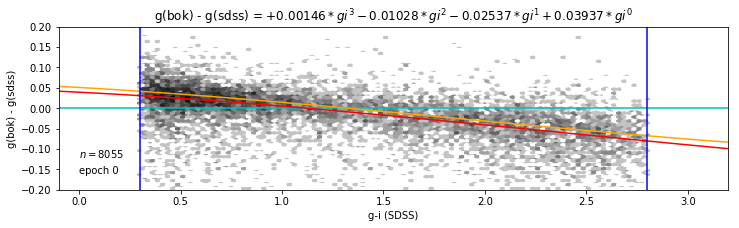

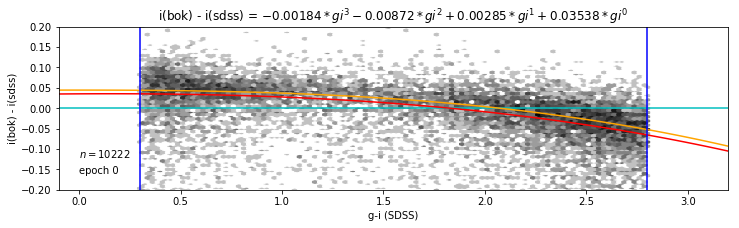

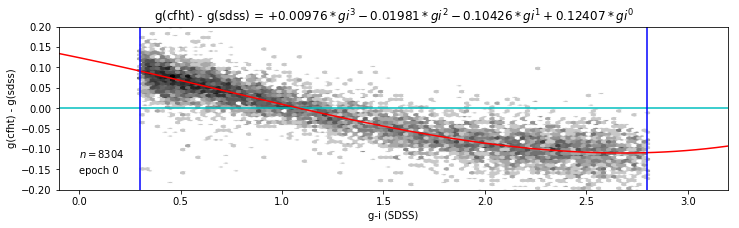

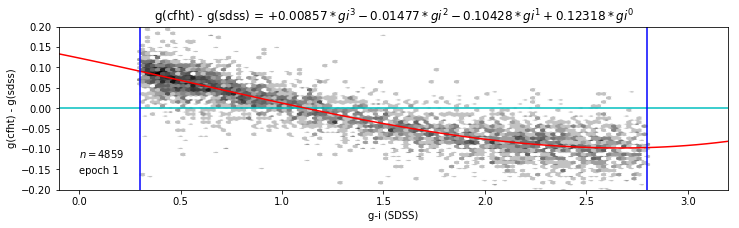

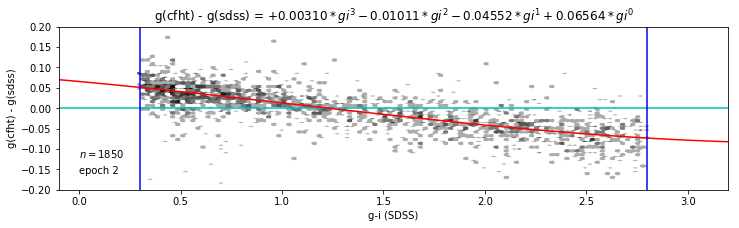

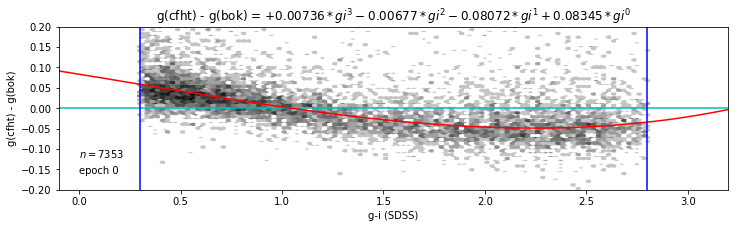

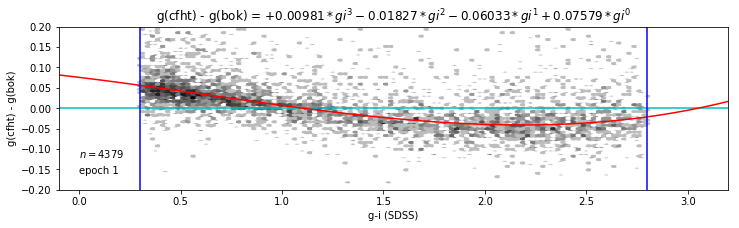

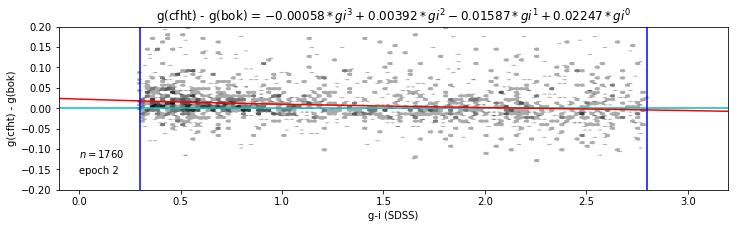

In [8]:
clrlo,clrhi = 0.3,2.8
clrsets = ['bok-sdss-g','bok-sdss-i','cfht-sdss-g','cfht-bok-g']
clrTab = Table(names=['photsys','refsys','filter','epoch','mjdmin','mjdmax','cterms'],
               dtype=['S4','S4','S1','i4','f4','f4','4f4'])
for clrset in clrsets:
    k,kref,b = clrset.split('-')
    ph = join(phot[k][b],sdssStars.refCat,'objId')
    if kref=='sdss':
            ph['dmag'] = ph['aperMag'] - ph[b]
    else:
        ph = join(ph,phot[kref][b]['objId','aperMag'],'objId')
        ph['dmag'] = ph['aperMag_1'] - ph['aperMag_2']
    ii = where( (ph['g-i']>clrlo) & (ph['g-i']<clrhi) &
                (abs(ph['dmag']) < 0.3) )[0]
    phg = ph[ii].group_by('colorEpoch')
    for ph in phg.groups:
        figure(figsize=(12,3))
        ax = subplot(111)
        cterms = dofit(ph['dmag'],ph['g-i'])
        epx = [0,]+colorEpochs[k]
        epoch = ph['colorEpoch'][0]
        clrTab.add_row((k,kref,b,epoch,epx[epoch],epx[epoch+1],cterms))
        ax.hexbin(ph['g-i'],ph['dmag'],cmap=get_cmap('gray_r'),bins='log')
        ax.axhline(0,c='c')
        xx = linspace(-1,4,100)
        if k=='bok' and kref=='sdss':
            oldcterms = loadtxt(os.path.join(rootDir,'bok','config','bok2sdss_%s_gicoeff.dat'%b))
            ax.plot(xx,polyval(oldcterms,xx),c='orange')
        ax.plot(xx,polyval(cterms,xx),c='r')
        ax.axvline(clrlo,c='b')
        ax.axvline(clrhi,c='b')
        order = len(cterms)-1
        polystr = ' '.join(['%+.5f*%s^%d'%(c,'gi',order-d)
                             for d,c in enumerate(cterms)])
        ax.set_title('{0}({1}) - {0}({2}) = ${3}$'.format(b,k,kref,polystr))
        ax.text(0.03,0.2,'$n={}$'.format(len(ph['dmag'])),transform=ax.transAxes)
        ax.text(0.03,0.1,'epoch {}'.format(epoch),transform=ax.transAxes)
        ax.set_xlim(-0.1,3.2)
        ax.set_ylim(-0.2,0.2)
        ax.set_ylabel('{0}({1}) - {0}({2})'.format(b,k,kref))
        ax.set_xlabel('g-i (SDSS)');

In [9]:
clrTab.write('colorterms.fits',overwrite=True)
print clrTab

photsys refsys filter epoch  mjdmin  mjdmax         cterms [4]       
------- ------ ------ ----- ------- ------- -------------------------
    bok   sdss      g     0     0.0 99999.0   0.00146087 .. 0.0393726
    bok   sdss      i     0     0.0 99999.0   -0.00184146 .. 0.035376
   cfht   sdss      g     0     0.0 57000.0    0.00976116 .. 0.124067
   cfht   sdss      g     1 57000.0 57350.0    0.00857256 .. 0.123175
   cfht   sdss      g     2 57350.0 99999.0   0.00309581 .. 0.0656377
   cfht    bok      g     0     0.0 57000.0   0.00735994 .. 0.0834469
   cfht    bok      g     1 57000.0 57350.0   0.00980538 .. 0.0757924
   cfht    bok      g     2 57350.0 99999.0 -0.000584958 .. 0.0224715


In [2]:
zpTab = Table.read('../bok/bokrm_zeropoints.fits')
obsDb = Table.read('../bok/config/sdssrm-bok.fits.gz')

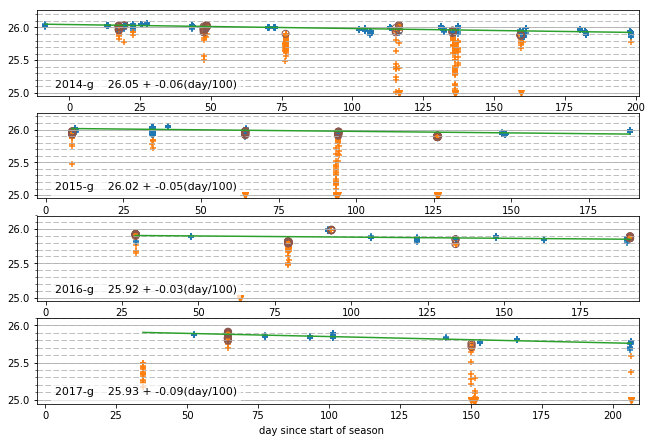

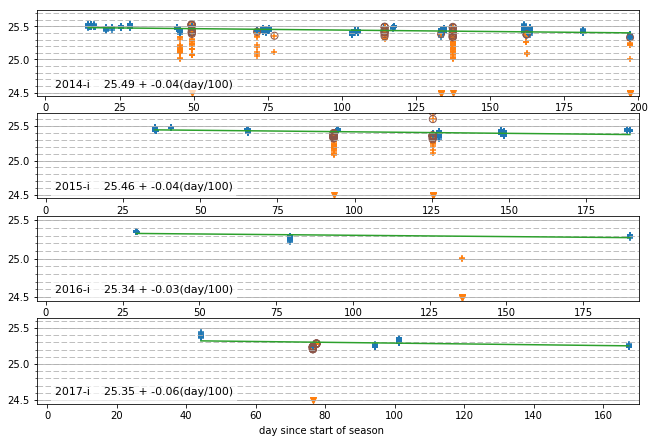

In [4]:
_ = bokrmgnostic.add_photometric_flag(zpTab,obsDb,doplot=True)